In [1]:
import numpy as np
import os
import glob
import cv2
from random import choice
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from sklearn.preprocessing import scale,LabelEncoder,LabelBinarizer,MinMaxScaler,OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
from sklearn import metrics
from sklearn.metrics import median_absolute_error
from scipy.stats import skew, norm
from scipy import stats
from datetime import date
from collections import Counter
import category_encoders as ce
import locale
from fuzzywuzzy import process
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from random import choices
import random
r = random.Random(101)
random.seed(101)

In [2]:
def load_house_attributes(inputPath):
 
 # load it using Pandas
    
    df = pd.read_csv(inputPath)
    #converting zip codes to object
    df.ZipCode = df.ZipCode.astype('object',copy=False)
    # dropping 'image_link','Address','Legal','Heating' columns
    df.drop(['image_link','Address','Legal','Heating'],axis=1,inplace=True)
   
  # return the data frame
    return df

In [3]:
SingleFamilyHome = load_house_attributes('../data/processed/SingleFamilyFinal.csv')

In [4]:
SingleFamilyHome.shape

(6348, 50)

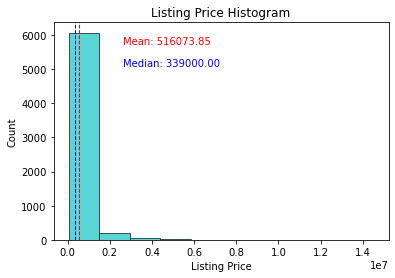

In [25]:
plt.hist(SingleFamilyHome.ListingPrice,bins=10, color='c', edgecolor='k', alpha=0.65)
plt.xlabel('Listing Price')
plt.ylabel('Count')
plt.title('Listing Price Histogram')
plt.axvline(SingleFamilyHome.ListingPrice.mean(),color='r', linestyle='dashed', linewidth=1)
plt.axvline(SingleFamilyHome.ListingPrice.median(),color='b', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(SingleFamilyHome.ListingPrice.mean()*5.1, max_ylim*0.9, 'Mean: {:.2f}'.format(SingleFamilyHome.ListingPrice.mean()),color='r')
plt.text(SingleFamilyHome.ListingPrice.mean()*5.1, max_ylim*0.8, 'Median: {:.2f}'.format(SingleFamilyHome.ListingPrice.median()),color='b')
plt.show()

<AxesSubplot:>

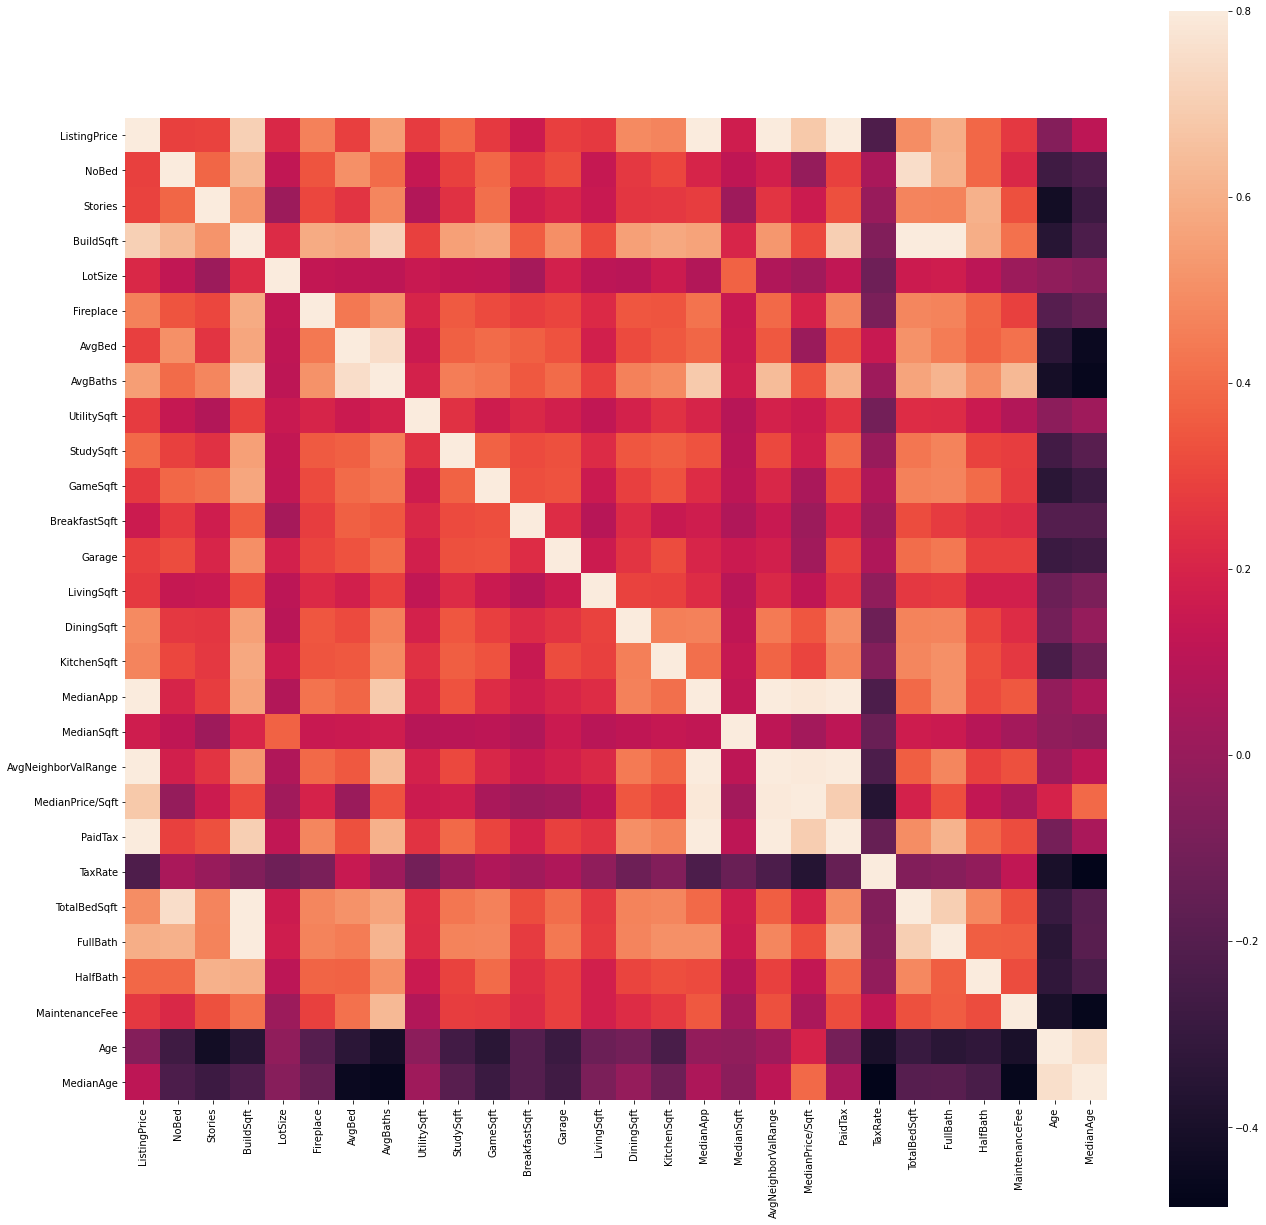

In [28]:
corr = SingleFamilyHome.select_dtypes(include=['float64', 'int64']).iloc[:,0:].corr()
f, ax = plt.subplots(figsize=(22, 22))
sns.heatmap(corr, vmax=.8, square=True)

In [29]:
high_correlated_features = ['MedianApp','AvgNeighborValRange','MedianPrice/Sqft','PaidTax',
                            'FullBath','BuildSqft','AvgBaths']

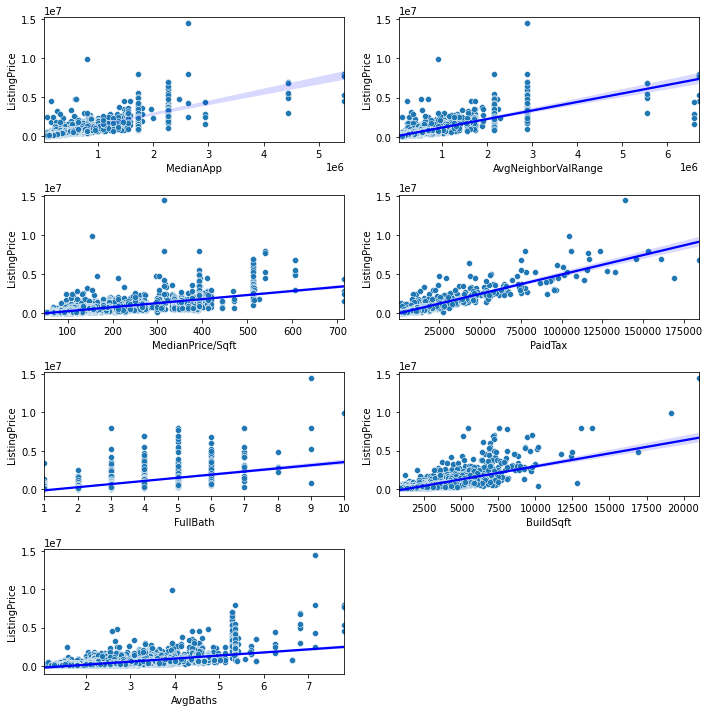

In [30]:
'''Plot appropriate graphs to comprehend the relationship'''
fig = plt.figure(figsize=(10,10))
spec = gridspec.GridSpec(ncols=2, nrows=4)
for i , var in enumerate(high_correlated_features):
    ax_i = fig.add_subplot(spec[i])
    sns.scatterplot(x=var, y='ListingPrice', data=SingleFamilyHome, palette='Blues_d')
    sns.regplot(x=var, y='ListingPrice', data=SingleFamilyHome, scatter=False, color='b')
    ax_i=plt.gca()
plt.tight_layout()
plt.show()

<AxesSubplot:ylabel='ZipCode'>

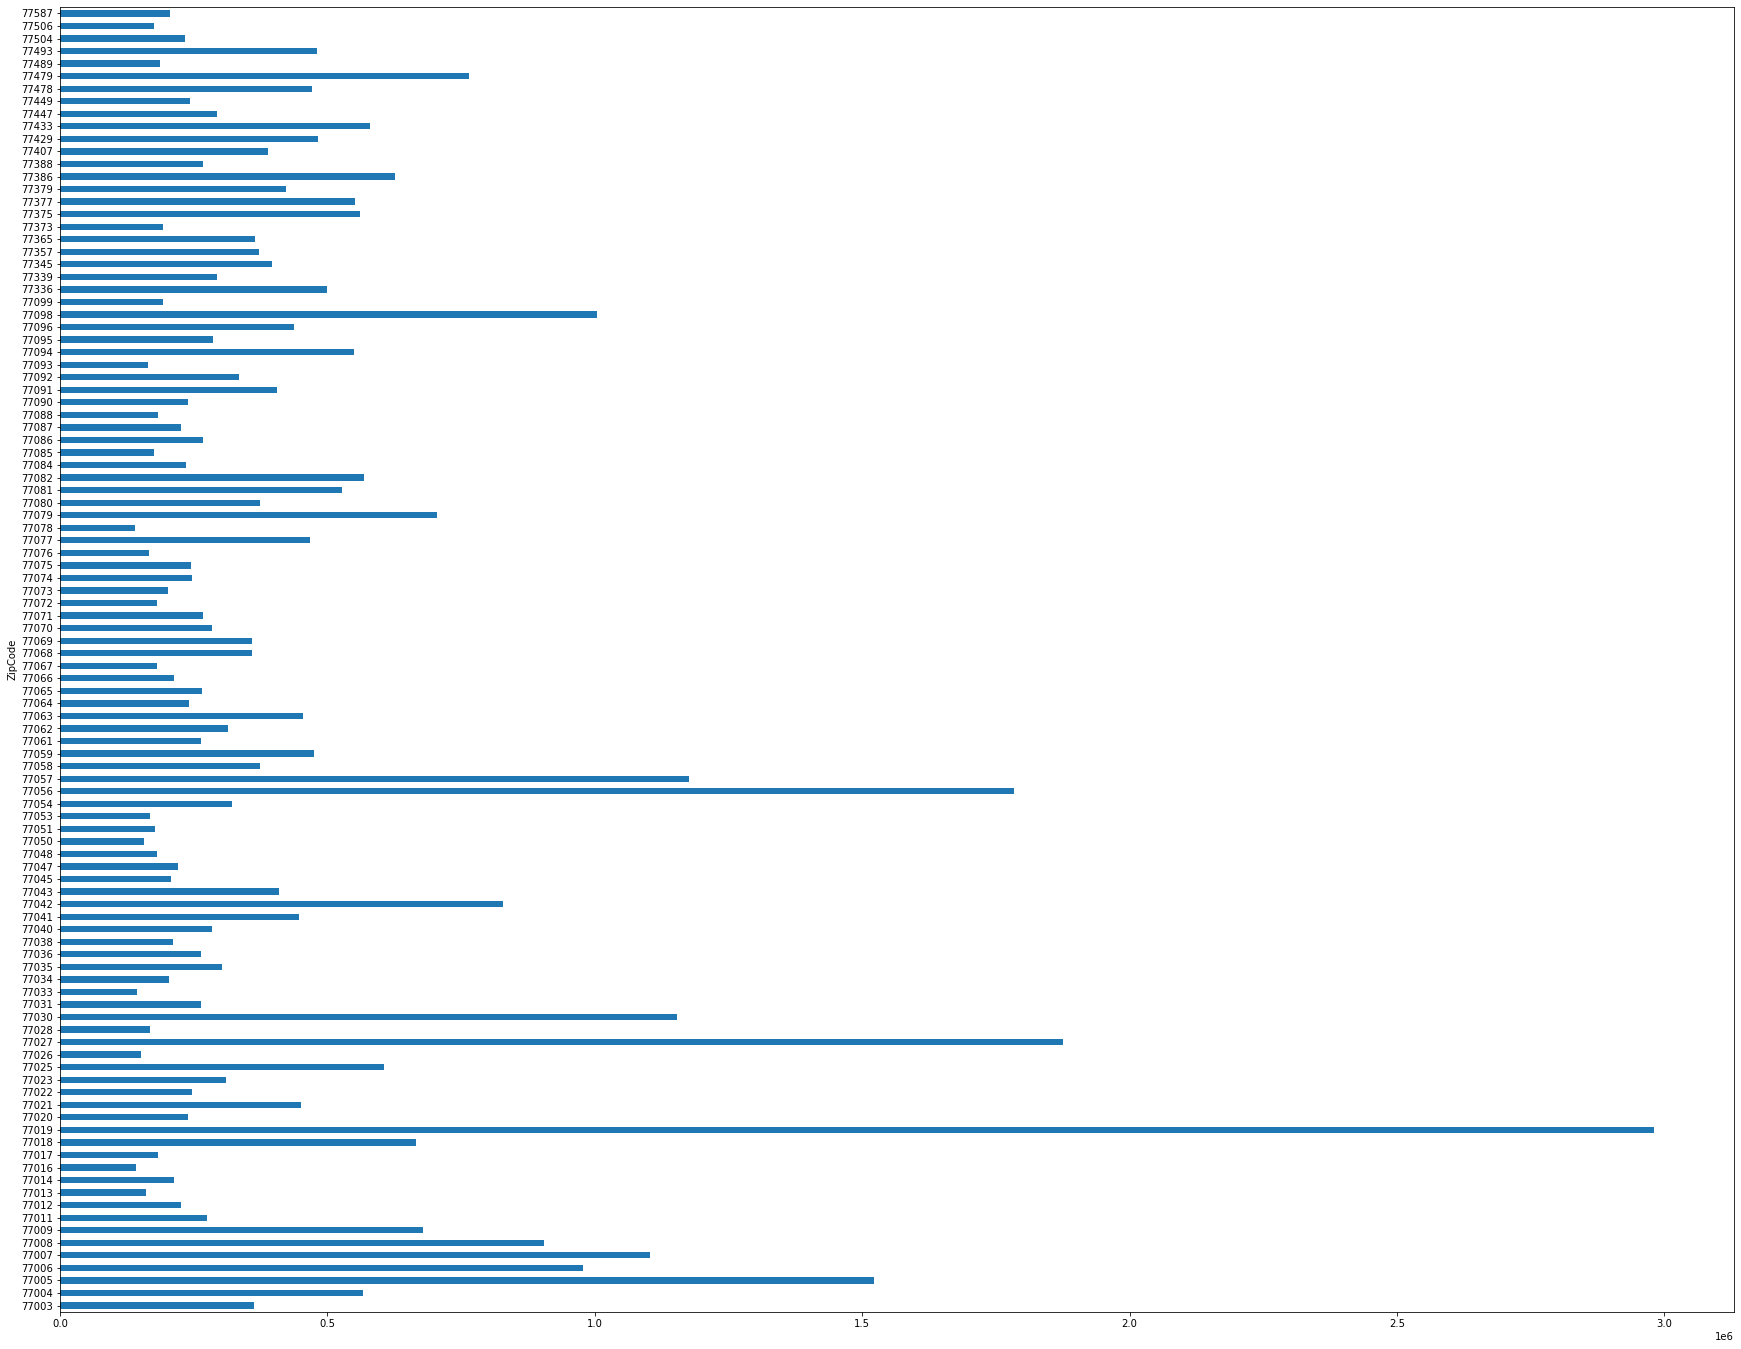

In [31]:
plt.figure(figsize=(30,24))
SingleFamilyHome.groupby('ZipCode')['ListingPrice'].mean().plot(kind='barh')

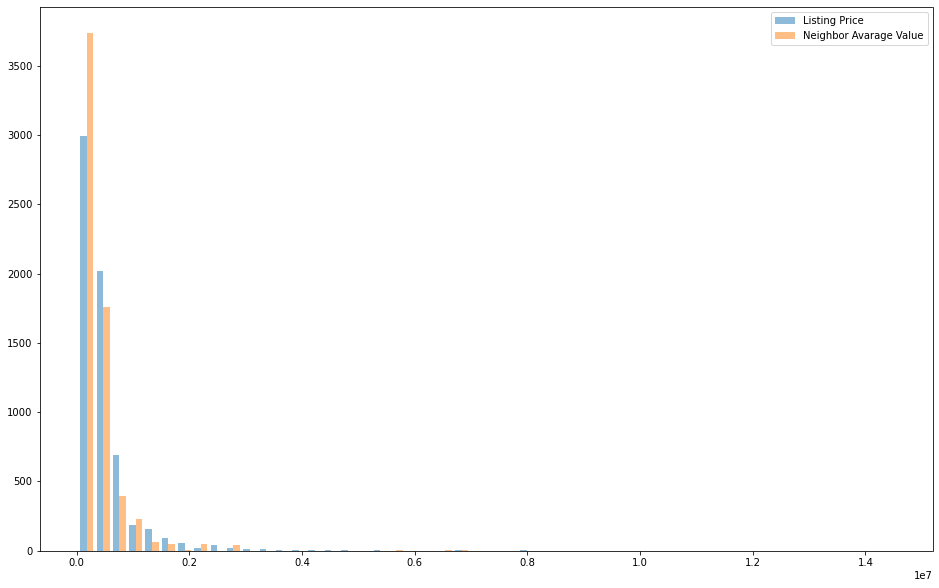

In [40]:
plt.figure(figsize=(16,10))
plt.hist([SingleFamilyHome.ListingPrice,SingleFamilyHome.AvgNeighborValRange], bins=50, alpha=0.5, label=['Listing Price','Neighbor Avarage Value'])
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Scatter Plot for Listing Price vs Year Biult')

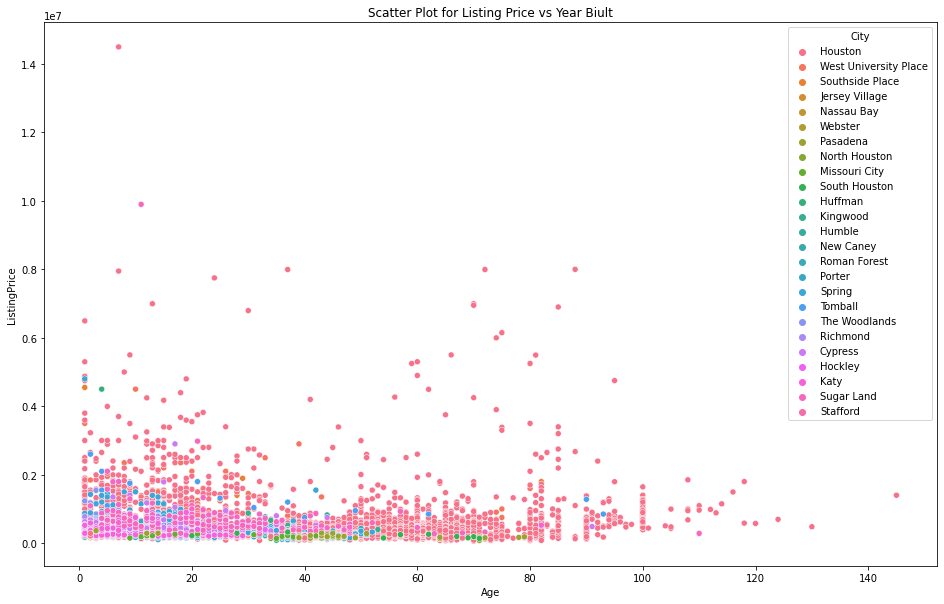

In [34]:
plt.figure(figsize=(16,10))
sns.scatterplot(x='Age', y='ListingPrice', data=SingleFamilyHome,hue='City')
plt.title('Scatter Plot for Listing Price vs Year Biult')

In [91]:
SingleFamilyHome

,ListingPrice,City,ZipCode,County,NoBed,Stories,Style,BuildSqft,LotSize,Fireplace,...,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath,MaintenanceFee,Age,MedianAge
0,364990,Houston,77003,Harris County,3,3.0,Contemporary/Modern,1736,1428.0,0,...,217000.0,192.51,2169.0,2.6554,430.000000,3,1,1195.0,1,2
1,419000,Houston,77003,Harris County,3,3.0,Traditional,2671,2006.0,1,...,443500.0,200.05,10366.0,2.5466,320.000000,3,1,2244.0,10,8
2,298800,Houston,77003,Harris County,3,1.0,Traditional,1972,5000.0,0,...,126500.0,147.06,5854.0,2.5716,616.000000,1,1,0.0,14,91
3,289900,Houston,77003,Harris County,2,2.0,Other,1688,1918.0,0,...,259000.0,181.62,6685.4,2.5465,330.000000,2,0,1500.0,14,15
4,284900,Houston,77003,Harris County,2,2.0,Traditional,1410,1845.0,0,...,259000.0,181.62,6299.0,2.5466,282.000000,2,1,1400.0,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,167000,South Houston,77587,Harris County,3,1.0,Traditional,1160,7100.0,0,...,103500.0,92.11,3108.0,2.8732,459.000000,1,1,0.0,54,57
6344,155000,South Houston,77587,Harris County,2,1.0,Traditional,839,7100.0,0,...,103500.0,92.11,2735.0,2.8732,242.916667,1,0,0.0,69,57
6345,149995,South Houston,77587,Harris County,4,1.0,Traditional,1563,7100.0,0,...,103500.0,92.11,2909.0,2.8732,441.000000,2,0,0.0,54,57
6346,137500,South Houston,77587,Harris County,3,1.0,Traditional,1461,7200.0,0,...,83500.0,118.87,2484.0,2.8732,383.000000,2,0,0.0,71,70


In [119]:
SingleFamilyHome.describe()

,ListingPrice,NoBed,Stories,BuildSqft,LotSize,Fireplace,AvgBed,AvgBaths,UtilitySqft,StudySqft,...,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath,MaintenanceFee,Age,MedianAge
count,6.348000e+03,6348.000000,6348.00000,6348.000000,6.348000e+03,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,...,6.348000e+03,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000
mean,5.160738e+05,3.733459,1.60775,2838.530718,1.135027e+04,0.844675,3.562284,2.905140,17.646299,53.578665,...,4.040187e+05,149.078907,10572.979109,2.631605,660.572321,2.557813,0.645558,594.598929,34.065532,37.517013
std,6.366832e+05,0.812209,0.57326,1332.939638,2.826106e+04,0.666426,0.495647,0.864892,36.180792,91.781833,...,4.686691e+05,83.678452,11571.933400,0.302077,242.844831,0.935091,0.608032,673.891572,23.943716,23.269579
min,6.000000e+04,1.000000,1.00000,754.000000,1.104000e+03,0.000000,1.910000,1.060000,0.000000,0.000000,...,3.550000e+04,48.120000,284.000000,0.610000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,2.359675e+05,3.000000,1.00000,1946.000000,6.466500e+03,0.000000,3.170000,2.277500,0.000000,0.000000,...,1.845000e+05,97.390000,5095.500000,2.421600,488.000000,2.000000,0.000000,0.000000,14.000000,17.000000
50%,3.390000e+05,4.000000,2.00000,2563.500000,8.165000e+03,1.000000,3.570000,2.770000,0.000000,0.000000,...,2.800000e+05,116.660000,7543.000000,2.540810,629.000000,2.000000,1.000000,450.000000,32.000000,38.000000
75%,5.500000e+05,4.000000,2.00000,3420.250000,1.020525e+04,1.000000,3.920000,3.420000,30.000000,130.000000,...,4.605000e+05,162.952500,11824.000000,2.763200,780.000000,3.000000,1.000000,800.000000,51.000000,55.000000
max,1.450000e+07,10.000000,3.00000,21032.000000,1.306800e+06,6.000000,7.920000,7.810000,727.000000,2070.000000,...,6.697000e+06,715.670000,183920.000000,3.902600,3235.000000,10.000000,6.000000,6930.000000,145.000000,118.000000


In [92]:
SingleFamilyHome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6348 entries, 0 to 6347
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ListingPrice         6348 non-null   int64  
 1   City                 6348 non-null   object 
 2   ZipCode              6348 non-null   object 
 3   County               6348 non-null   object 
 4   NoBed                6348 non-null   int64  
 5   Stories              6348 non-null   float64
 6   Style                6348 non-null   object 
 7   BuildSqft            6348 non-null   int64  
 8   LotSize              6348 non-null   float64
 9   Fireplace            6348 non-null   int64  
 10  Cooling              6348 non-null   object 
 11  IceMaker             6348 non-null   object 
 12  Microwave            6348 non-null   object 
 13  Compactor            6348 non-null   object 
 14  Dishwasher           6348 non-null   object 
 15  Disposal             6348 non-null   o

In [51]:
def process_house_attributes(df, train, test):
    # initialize the column names of the continuous data
    continuous = train.columns[train.dtypes!='object']
    categorical = train.columns[train.dtypes=='object']
    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])

    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoing, all output features are now in the range [0, 1])
    categoricalBinarizer = ce.BinaryEncoder().fit(df[categorical])
    trainCategorical = categoricalBinarizer.transform(train[categorical])
    testCategorical = categoricalBinarizer.transform(test[categorical])

    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])

    # return the concatenated training and testing data
    return (trainX, testX)

def create_mlp(dim, regress=False):
   # define our MLP network
    model = Sequential()
    
    model.add(Dense(32, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))

   # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

# return our model
    return model

In [94]:
(train, test) = train_test_split(SingleFamilyHome, test_size=0.3, random_state=40)

In [95]:
print(train.shape,test.shape)

(4443, 50) (1905, 50)


find the largest house price in the training set and use it to scale our house prices to the range [0, 1] (this will lead to better training and convergence)

In [96]:
maxPrice = train["ListingPrice"].max()
y_train = train["ListingPrice"] /maxPrice
y_test = test["ListingPrice"] /maxPrice

In [97]:
train.drop('ListingPrice',axis=1,inplace=True)
test.drop('ListingPrice',axis = 1, inplace=True)

In [98]:
(X_train, X_test) = process_house_attributes(SingleFamilyHome, train, test)

In [99]:
X_train.shape

(4443, 115)

In [102]:
model = create_mlp(X_train.shape[1], regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

In [111]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),epochs=200, batch_size=10,callbacks=[early_stopping])

Train on 4443 samples, validate on 1905 samples
Epoch 1/200
4443/4443 [==============================] - 2s 481us/sample - loss: 11.0595 - val_loss: 13.8007
Epoch 2/200
4443/4443 [==============================] - 2s 385us/sample - loss: 10.9496 - val_loss: 14.8458
Epoch 3/200
4443/4443 [==============================] - 2s 424us/sample - loss: 10.5155 - val_loss: 13.0425
Epoch 4/200
4443/4443 [==============================] - 2s 436us/sample - loss: 10.5066 - val_loss: 12.4623
Epoch 5/200
4443/4443 [==============================] - 2s 392us/sample - loss: 10.4821 - val_loss: 15.2122
Epoch 6/200
4443/4443 [==============================] - 2s 460us/sample - loss: 11.0986 - val_loss: 12.1325
Epoch 7/200
4443/4443 [==============================] - 2s 469us/sample - loss: 10.5164 - val_loss: 12.2726
Epoch 8/200
4443/4443 [==============================] - 2s 426us/sample - loss: 10.7734 - val_loss: 12.4974
Epoch 9/200
4443/4443 [==============================] - 2s 460us/sample - loss:

In [112]:
y_preds = model.predict(X_test)

In [113]:
result = pd.DataFrame({'ActualPrice':y_test*maxPrice,'PredictedPrice':y_preds.flatten()*maxPrice})

In [114]:
result 

,ActualPrice,PredictedPrice
1887,2999000.0,3.046495e+06
5581,429000.0,4.232936e+05
3095,999000.0,1.114198e+06
4520,349000.0,3.310889e+05
1257,275000.0,2.543160e+05
...,...,...
5849,329500.0,3.333394e+05
2123,279900.0,2.614359e+05
540,220000.0,2.209780e+05
5948,222000.0,2.328428e+05


In [115]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = y_preds.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
median = np.median(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] Median house price: {}, std house price: {}".format(
    locale.currency(SingleFamilyHome["ListingPrice"].median(), grouping=True),
    locale.currency(SingleFamilyHome["ListingPrice"].std(), grouping=True)))
print("[INFO] Median absolute percentage difference: {:.2f}%, std absolute percentage difference: {:.2f}%".format(median, std))

[INFO] Median house price: $339,000.00, std house price: $636,683.19
[INFO] Median absolute percentage difference: 9.95%, std absolute percentage difference: 13.52%


In [116]:
absdiff = np.abs(diff)

In [117]:
np.median(absdiff)

0.002358230621033703

In [118]:
median_absolute_error(y_test, y_preds.flatten())*maxPrice

34194.34400498869

### Image Model

In [52]:
def load_house_images(df, inputPath):
    # initialize our images array (i.e., the house images themselves)
    images = []

    # loop over the indexes of the houses
    for i in tqdm(df.index.values):
        # find the four images for the house and sort the file paths,
        # ensuring the four are always in the *same order*
        basePath = os.path.sep.join([inputPath, "{}_*".format(i)])
        housePaths = sorted(list(glob.glob(basePath)))
        # initialize our list of input images along with the output image
        # after *combining* the four input images
        inputImages = []
        outputImage = np.zeros((64, 64, 3), dtype="uint8")

        # loop over the input house paths
        for housePath in housePaths:
            # load the input image, resize it to be 32 32, and then
            # update the list of input images
            image = cv2.imread(housePath)
            image = cv2.resize(image, (32, 32))
            inputImages.append(image)

        # tile the four input images in the output image such the first
        # image goes in the top-right corner, the second image in the
        # top-left corner, the third image in the bottom-right corner,
        # and the final image in the bottom-left corner
        outputImage[0:32, 0:32] = inputImages[1]
        outputImage[0:32, 32:64] = inputImages[3]
        outputImage[32:64, 32:64] = inputImages[0]
        outputImage[32:64, 0:32] = inputImages[2]

        # add the tiled image to our set of images the network will be
        # trained on
        images.append(outputImage)

    # return our set of images
    return np.array(images)

def create_cnn(width, height, depth, filters=(8,16), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [40]:
# listing_price = SingleFamilyHome.ListingPrice.to_list()
images  = load_house_images(SingleFamilyHome, '../data/processed/Image/')

100%|██████████████████████████████████████████████████████████████████████████████| 6348/6348 [17:52<00:00,  5.92it/s]


In [42]:
images = images / 255.0

In [52]:
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(SingleFamilyHome, images, test_size=0.25, random_state=41)

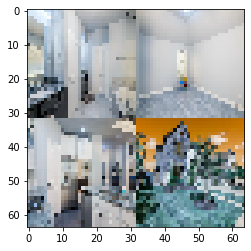

In [53]:
plt.imshow(trainImagesX[0])

In [54]:
trainAttrX

,ListingPrice,City,ZipCode,County,NoBed,Stories,Style,BuildSqft,LotSize,Fireplace,...,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath,MaintenanceFee,Age,MedianAge
6295,425000,Katy,77493,Harris County,4,2.0,Traditional,3116,6498.0,1,...,305000.0,125.55,12169.000000,3.6598,785.0,3,1,1150.0,3,2
5284,325000,Spring,77386,Montgomery County,3,1.5,Traditional,2552,6108.0,0,...,330500.0,121.19,9733.000000,3.2942,471.0,2,1,650.0,3,4
3315,186000,Houston,77082,Harris County,5,1.0,Traditional,2441,4800.0,1,...,147500.0,103.37,4017.000000,2.5161,711.0,3,0,250.0,39,39
2978,550000,Houston,77077,Harris County,4,2.0,Traditional,3444,4170.0,2,...,525000.0,158.50,11356.000000,2.4216,728.0,3,1,2500.0,17,23
4494,275000,Kingwood,77345,Harris County,4,2.0,Traditional,2462,9430.0,1,...,293000.0,101.27,6972.000000,2.7108,623.0,2,1,435.0,37,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,355000,Spring,77379,Harris County,3,1.0,Traditional,3090,10513.0,1,...,299000.0,94.79,4140.000000,2.7687,723.0,2,1,635.0,23,21
4066,499500,Houston,77096,Harris County,4,1.0,Traditional,3239,9372.0,0,...,542500.0,139.32,11384.000000,2.4216,310.0,3,0,450.0,65,59
3980,245000,Houston,77095,Harris County,4,2.0,Traditional,2380,5000.0,1,...,238500.0,93.98,4274.000000,2.5143,530.0,2,1,560.0,26,37
931,289000,Houston,77025,Harris County,2,3.0,Contemporary/Modern,2078,2003.0,0,...,254000.0,138.44,6826.000000,2.4216,302.0,2,1,1193.0,11,12


In [55]:
maxPrice = trainAttrX["ListingPrice"].max()
trainY = trainAttrX["ListingPrice"]/ maxPrice
testY = testAttrX["ListingPrice"]/ maxPrice

In [56]:
model = create_cnn(64, 64, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
#early_stopping = EarlyStopping(monitor='loss', patience=30)

In [57]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
activation_5 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0   

In [58]:
history =model.fit(x=trainImagesX, y=trainY,validation_data=(testImagesX, testY),epochs=200, batch_size=20)

Train on 4761 samples, validate on 1587 samples
Epoch 1/200
4761/4761 [==============================] - 53s 11ms/sample - loss: 735.5478 - val_loss: 642.1670
Epoch 2/200
4761/4761 [==============================] - 51s 11ms/sample - loss: 139.2263 - val_loss: 178.8818
Epoch 3/200
4761/4761 [==============================] - 51s 11ms/sample - loss: 65.7365 - val_loss: 56.3035
Epoch 4/200
4761/4761 [==============================] - 52s 11ms/sample - loss: 48.3441 - val_loss: 41.4278
Epoch 5/200
4761/4761 [==============================] - 51s 11ms/sample - loss: 44.2313 - val_loss: 38.4126
Epoch 6/200
4761/4761 [==============================] - 56s 12ms/sample - loss: 41.5516 - val_loss: 39.2288
Epoch 7/200
4761/4761 [==============================] - 65s 14ms/sample - loss: 40.7716 - val_loss: 38.3776
Epoch 8/200
4761/4761 [==============================] - 58s 12ms/sample - loss: 39.9066 - val_loss: 38.4563
Epoch 9/200
4761/4761 [==============================] - 61s 13ms/sample - l

4761/4761 [==============================] - 52s 11ms/sample - loss: 25.2666 - val_loss: 35.8507
Epoch 76/200
4761/4761 [==============================] - 52s 11ms/sample - loss: 25.0008 - val_loss: 42.7648
Epoch 77/200
4761/4761 [==============================] - 51s 11ms/sample - loss: 26.1316 - val_loss: 39.9152
Epoch 78/200
4761/4761 [==============================] - 52s 11ms/sample - loss: 25.2349 - val_loss: 37.1371
Epoch 79/200
4761/4761 [==============================] - 52s 11ms/sample - loss: 24.8828 - val_loss: 39.1216
Epoch 80/200
4761/4761 [==============================] - 52s 11ms/sample - loss: 25.0196 - val_loss: 36.9523
Epoch 81/200
4761/4761 [==============================] - 51s 11ms/sample - loss: 24.4213 - val_loss: 39.8818
Epoch 82/200
4761/4761 [==============================] - 52s 11ms/sample - loss: 24.2768 - val_loss: 41.1879
Epoch 83/200
4761/4761 [==============================] - 52s 11ms/sample - loss: 24.2931 - val_loss: 36.2736
Epoch 84/200
4761/4761 

In [59]:
# make predictions on the testing data

preds = model.predict(testImagesX)

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.median(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] median house price: {}, std house price: {}".format(
	locale.currency(SingleFamilyHome["ListingPrice"].median(), grouping=True),
	locale.currency(SingleFamilyHome["ListingPrice"].std(), grouping=True)))
print("[INFO] median absolute percentage error: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] median house price: $339,000.00, std house price: $636,683.19
[INFO] median absolute percentage error: 33.71%, std: 30.08%


In [60]:
from sklearn.metrics import median_absolute_error

median_absolute_error(testY, preds.flatten())*maxPrice

109041.1196857691

## Mixing Model

In [53]:
images  = load_house_images(SingleFamilyHome, '../data/processed/Image/')
images = images / 255.0


100%|██████████████████████████████████████████████████████████████████████████████| 6348/6348 [10:31<00:00, 10.05it/s]


In [54]:
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(SingleFamilyHome, images, test_size=0.30, random_state=40)

In [55]:
trainAttrX

,ListingPrice,City,ZipCode,County,NoBed,Stories,Style,BuildSqft,LotSize,Fireplace,...,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath,MaintenanceFee,Age,MedianAge
2775,190000,Houston,77073,Harris County,4,2.0,Traditional,2252,4000.0,0,...,149000.0,87.29000,4262.0,3.1395,588.0,2,1,750.0,14,14
2894,889000,Houston,77077,Harris County,4,2.0,Traditional,4699,14000.0,1,...,436500.0,138.38679,9346.0,2.4216,900.0,4,1,650.0,49,50
1528,327000,Houston,77042,Harris County,4,2.0,Georgian,2062,11200.0,0,...,332500.0,164.53000,7914.0,2.4216,586.0,2,1,760.0,56,53
3441,195000,Houston,77084,Harris County,3,1.0,Traditional,1528,8450.0,1,...,149500.0,98.50000,3759.0,2.6248,429.0,2,0,475.0,47,45
1907,1849000,Houston,77056,Harris County,4,2.0,Contemporary/Modern,4541,4694.0,1,...,1004000.0,238.53000,22883.0,2.4760,970.0,4,1,2400.0,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5426,199900,Spring,77388,Harris County,4,1.0,Other,2425,10234.0,1,...,176500.0,89.02000,4840.0,2.6086,753.0,2,0,250.0,49,48
3064,684900,Houston,77079,Harris County,5,2.0,Traditional,3162,10735.0,1,...,745500.0,266.65000,15303.0,2.5056,850.0,2,1,732.0,54,55
6309,220000,Pasadena,77504,Harris County,3,2.0,Traditional,1710,6120.0,1,...,166000.0,117.38000,4868.0,2.7436,852.0,2,1,0.0,41,41
6151,788000,Sugar Land,77479,Fort bend County,5,2.0,Mediterranean,6380,11839.0,2,...,332500.0,113.67000,18462.0,2.4920,1266.0,6,1,1120.0,22,23


In [56]:
maxPrice = trainAttrX["ListingPrice"].max()
trainY = trainAttrX["ListingPrice"]/ maxPrice
testY = testAttrX["ListingPrice"]/ maxPrice

In [57]:
trainAttrX.drop('ListingPrice',axis=1,inplace=True)
testAttrX.drop('ListingPrice',axis = 1, inplace=True)

In [58]:
trainAttrX

,City,ZipCode,County,NoBed,Stories,Style,BuildSqft,LotSize,Fireplace,Cooling,...,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath,MaintenanceFee,Age,MedianAge
2775,Houston,77073,Harris County,4,2.0,Traditional,2252,4000.0,0,Central,...,149000.0,87.29000,4262.0,3.1395,588.0,2,1,750.0,14,14
2894,Houston,77077,Harris County,4,2.0,Traditional,4699,14000.0,1,Central,...,436500.0,138.38679,9346.0,2.4216,900.0,4,1,650.0,49,50
1528,Houston,77042,Harris County,4,2.0,Georgian,2062,11200.0,0,Central,...,332500.0,164.53000,7914.0,2.4216,586.0,2,1,760.0,56,53
3441,Houston,77084,Harris County,3,1.0,Traditional,1528,8450.0,1,Central,...,149500.0,98.50000,3759.0,2.6248,429.0,2,0,475.0,47,45
1907,Houston,77056,Harris County,4,2.0,Contemporary/Modern,4541,4694.0,1,Central,...,1004000.0,238.53000,22883.0,2.4760,970.0,4,1,2400.0,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5426,Spring,77388,Harris County,4,1.0,Other,2425,10234.0,1,Central,...,176500.0,89.02000,4840.0,2.6086,753.0,2,0,250.0,49,48
3064,Houston,77079,Harris County,5,2.0,Traditional,3162,10735.0,1,Central,...,745500.0,266.65000,15303.0,2.5056,850.0,2,1,732.0,54,55
6309,Pasadena,77504,Harris County,3,2.0,Traditional,1710,6120.0,1,Central,...,166000.0,117.38000,4868.0,2.7436,852.0,2,1,0.0,41,41
6151,Sugar Land,77479,Fort bend County,5,2.0,Mediterranean,6380,11839.0,2,Central,...,332500.0,113.67000,18462.0,2.4920,1266.0,6,1,1120.0,22,23


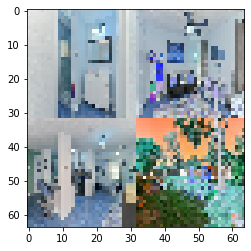

In [59]:
plt.imshow(trainImagesX[3])

In [60]:
(trainAttrX, testAttrX) = process_house_attributes(SingleFamilyHome,trainAttrX, testAttrX)

In [61]:
trainAttrX.shape

(4443, 115)

In [65]:
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
Mixmodel = Model(inputs=[mlp.input, cnn.input], outputs=x)

# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
Mixmodel.compile(loss="mean_absolute_percentage_error", optimizer=opt)
early_stopping = EarlyStopping(monitor='loss', patience=30)

In [66]:
Mixmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 8)    224         input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 64, 64, 8)    32          activation_4[0][0]               
____________________________________________________________________________________________

In [ ]:
Mixhistory =Mixmodel.fit(x=[trainAttrX, trainImagesX], y=trainY,validation_data=([testAttrX, testImagesX], testY),
                   epochs=200, batch_size=10)

Train on 4443 samples, validate on 1905 samples
Epoch 1/200
4443/4443 [==============================] - 58s 13ms/sample - loss: 9.1272 - val_loss: 13.3263
Epoch 2/200
4443/4443 [==============================] - 56s 13ms/sample - loss: 9.1463 - val_loss: 14.4754
Epoch 3/200
4443/4443 [==============================] - 61s 14ms/sample - loss: 9.0797 - val_loss: 12.6884
Epoch 4/200
4443/4443 [==============================] - 60s 13ms/sample - loss: 8.7873 - val_loss: 12.9652
Epoch 5/200
4443/4443 [==============================] - 54s 12ms/sample - loss: 9.1506 - val_loss: 13.5151
Epoch 6/200
4443/4443 [==============================] - 60s 13ms/sample - loss: 9.5386 - val_loss: 12.8478
Epoch 7/200
4443/4443 [==============================] - 55s 12ms/sample - loss: 9.3282 - val_loss: 12.8848
Epoch 8/200
4443/4443 [==============================] - 60s 14ms/sample - loss: 9.5273 - val_loss: 13.3345
Epoch 9/200
4443/4443 [==============================] - 59s 13ms/sample - loss: 9.2605 

In [68]:
# make predictions on the testing data

preds = Mixmodel.predict([testAttrX, testImagesX])

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the median and standard deviation of the absolute percentage
# difference
mean = np.median(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(locale.currency(SingleFamilyHome["ListingPrice"].median(), grouping=True),
                                                                locale.currency(SingleFamilyHome["ListingPrice"].std(), grouping=True)))
print("[INFO] median absolute: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $339,000.00, std house price: $636,683.19
[INFO] median absolute: 10.26%, std: 12.52%


In [78]:
result = pd.DataFrame({'ActualPrice':testY*maxPrice,'PredictedPrice':preds.flatten()*maxPrice})

In [79]:
result.head()

,ActualPrice,PredictedPrice
1887,2999000.0,2.321658e+06
5581,429000.0,4.159154e+05
3095,999000.0,1.098711e+06
4520,349000.0,3.214963e+05
1257,275000.0,2.781738e+05


In [103]:
median_absolute_error(testY, preds.flatten())*maxPrice

27292.02383959293

In [102]:
Mixmodel.save('../models/FinalMixModel')

In [50]:
from tensorflow import keras
Mixmodel = keras.models.load_model('../models/FinalMixModel')

AttributeError: 'str' object has no attribute 'decode'

## Second Mix Model

In [9]:
def load_house_image(df, inputPath,order):
    # initialize our images array (i.e., the house images themselves)
    images = []

    # loop over the indexes of the houses
    for i in tqdm(df.index.values):
        # find the four images for the house and sort the file paths,
        # ensuring the four are always in the *same order*
        basePath = os.path.sep.join([inputPath, "{}_*".format(i)])
        housePaths = sorted(list(glob.glob(basePath)))
        # initialize our list of input images along with the output image
        # after *combining* the four input images
        inputImages = []
        #outputImage = np.zeros((32, 64, 3), dtype="uint8")

        # loop over the input house paths
        for housePath in housePaths:
            # load the input image, resize it to be 32 32, and then
            # update the list of input images
            image = cv2.imread(housePath)
            image = cv2.resize(image, (32, 32))
            inputImages.append(image)

                
        # add the tiled image to our set of images the network will be
        # trained on
        images.append(inputImages[order])

    # return our set of images
    return np.array(images)

In [10]:
exterior  = load_house_image(SingleFamilyHome, '../data/processed/Image/',0)

100%|██████████████████████████████████████████████████████████████████████████████| 6348/6348 [10:23<00:00, 10.18it/s]


In [11]:
bathroom  = load_house_image(SingleFamilyHome, '../data/processed/Image/',1)

100%|██████████████████████████████████████████████████████████████████████████████| 6348/6348 [09:33<00:00, 11.07it/s]


In [12]:
kitchen = load_house_image(SingleFamilyHome, '../data/processed/Image/',2)

100%|██████████████████████████████████████████████████████████████████████████████| 6348/6348 [10:26<00:00, 10.14it/s]


In [13]:
living = load_house_image(SingleFamilyHome, '../data/processed/Image/',3)

100%|██████████████████████████████████████████████████████████████████████████████| 6348/6348 [09:45<00:00, 10.84it/s]


In [14]:
exterior = exterior / 255.0
bathroom = bathroom / 255.0
kitchen = kitchen / 255.0
living = living / 255.0

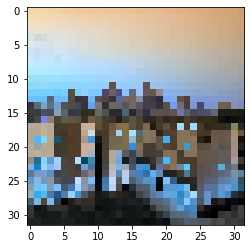

In [15]:
plt.imshow(exterior[0])

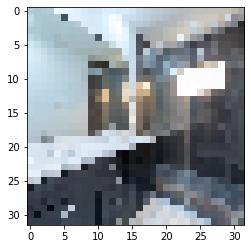

In [16]:
plt.imshow(bathroom[0])


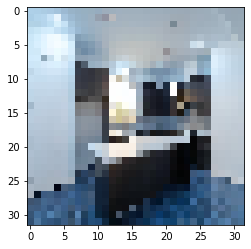

In [17]:
plt.imshow(kitchen[0])


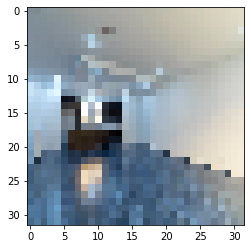

In [18]:
plt.imshow(living[0])

In [19]:
(trainAttrX, testAttrX, trainExterior, testExterior,trainBathroom, testBathroom,
trainKitchen, testkitchen,trainLiving, testLiving) = train_test_split(SingleFamilyHome, exterior,bathroom,
                                                                      kitchen,living, test_size=0.30, random_state=41)

In [20]:
trainAttrX

,ListingPrice,City,ZipCode,County,NoBed,Stories,Style,BuildSqft,LotSize,Fireplace,...,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath,MaintenanceFee,Age,MedianAge
6104,549800,Sugar Land,77479,Fort bend County,6,2.0,Traditional,4193,10518.0,2,...,566500.0,130.18,12710.000000,2.2110,1330.0,3,1,816.0,29,29
3727,215000,Houston,77090,Harris County,5,2.0,Other,2873,8970.0,1,...,188000.0,68.14,4556.000000,2.5804,905.0,3,0,0.0,50,48
747,2599999,Houston,77019,Harris County,4,2.0,Colonial,3876,9380.0,2,...,2879000.0,512.55,41752.000000,2.5304,918.0,3,1,2150.0,81,72
1638,318900,Houston,77043,Harris County,4,1.0,Ranch,1754,9760.0,0,...,218000.0,155.57,5504.000000,2.6056,450.0,2,0,200.0,60,65
6200,879500,Sugar Land,77479,Fort bend County,5,2.0,Traditional,4719,11997.0,1,...,613000.0,160.20,16491.000000,2.2110,1109.0,3,1,790.0,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,355000,Spring,77379,Harris County,3,1.0,Traditional,3090,10513.0,1,...,299000.0,94.79,4140.000000,2.7687,723.0,2,1,635.0,23,21
4066,499500,Houston,77096,Harris County,4,1.0,Traditional,3239,9372.0,0,...,542500.0,139.32,11384.000000,2.4216,310.0,3,0,450.0,65,59
3980,245000,Houston,77095,Harris County,4,2.0,Traditional,2380,5000.0,1,...,238500.0,93.98,4274.000000,2.5143,530.0,2,1,560.0,26,37
931,289000,Houston,77025,Harris County,2,3.0,Contemporary/Modern,2078,2003.0,0,...,254000.0,138.44,6826.000000,2.4216,302.0,2,1,1193.0,11,12


In [21]:
maxPrice = trainAttrX["ListingPrice"].max()
trainY = trainAttrX["ListingPrice"]/ maxPrice
testY = testAttrX["ListingPrice"]/ maxPrice

In [22]:
trainAttrX.drop('ListingPrice',axis=1,inplace=True)
testAttrX.drop('ListingPrice',axis = 1, inplace=True)

In [23]:
trainAttrX

,City,ZipCode,County,NoBed,Stories,Style,BuildSqft,LotSize,Fireplace,Cooling,...,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath,MaintenanceFee,Age,MedianAge
6104,Sugar Land,77479,Fort bend County,6,2.0,Traditional,4193,10518.0,2,Central,...,566500.0,130.18,12710.000000,2.2110,1330.0,3,1,816.0,29,29
3727,Houston,77090,Harris County,5,2.0,Other,2873,8970.0,1,Central,...,188000.0,68.14,4556.000000,2.5804,905.0,3,0,0.0,50,48
747,Houston,77019,Harris County,4,2.0,Colonial,3876,9380.0,2,Central,...,2879000.0,512.55,41752.000000,2.5304,918.0,3,1,2150.0,81,72
1638,Houston,77043,Harris County,4,1.0,Ranch,1754,9760.0,0,Central,...,218000.0,155.57,5504.000000,2.6056,450.0,2,0,200.0,60,65
6200,Sugar Land,77479,Fort bend County,5,2.0,Traditional,4719,11997.0,1,Central,...,613000.0,160.20,16491.000000,2.2110,1109.0,3,1,790.0,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,Spring,77379,Harris County,3,1.0,Traditional,3090,10513.0,1,Central,...,299000.0,94.79,4140.000000,2.7687,723.0,2,1,635.0,23,21
4066,Houston,77096,Harris County,4,1.0,Traditional,3239,9372.0,0,Central,...,542500.0,139.32,11384.000000,2.4216,310.0,3,0,450.0,65,59
3980,Houston,77095,Harris County,4,2.0,Traditional,2380,5000.0,1,Central,...,238500.0,93.98,4274.000000,2.5143,530.0,2,1,560.0,26,37
931,Houston,77025,Harris County,2,3.0,Contemporary/Modern,2078,2003.0,0,Central,...,254000.0,138.44,6826.000000,2.4216,302.0,2,1,1193.0,11,12


In [24]:
(trainAttrX, testAttrX) = process_house_attributes(SingleFamilyHome,trainAttrX, testAttrX)

In [43]:
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn_exterior = create_cnn(32, 32, 3, regress=False)
cnn_bathroom = create_cnn(32, 32, 3, regress=False)
cnn_kitchen = create_cnn(32, 32, 3, regress=False)
cnn_living = create_cnn(32, 32, 3, regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn_exterior.output,cnn_bathroom.output,cnn_kitchen.output,cnn_living.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(100, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
Mixmodel2 = Model(inputs=[mlp.input, cnn_exterior.input,cnn_bathroom.input,cnn_kitchen.input,cnn_living.input],
                 outputs=x)

# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
Mixmodel2.compile(loss="mean_absolute_percentage_error", optimizer=opt)
early_stopping = EarlyStopping(monitor='loss', patience=30)

In [44]:
Mixmodel2.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 32, 32, 3)]  0                                            
___________________________________________________________________________________________

In [45]:
history =Mixmodel2.fit(x=[trainAttrX, trainExterior,trainBathroom,trainKitchen,trainLiving],
                       y=trainY,validation_data=([testAttrX, testExterior, testBathroom,testkitchen,testLiving], 
                                                 testY),epochs=200, batch_size=10)

Train on 4443 samples, validate on 1905 samples
Epoch 1/200
4443/4443 [==============================] - 26s 6ms/sample - loss: 386.8212 - val_loss: 126.0214
Epoch 2/200
4443/4443 [==============================] - 22s 5ms/sample - loss: 150.2027 - val_loss: 68.8850
Epoch 3/200
4443/4443 [==============================] - 28s 6ms/sample - loss: 100.2279 - val_loss: 57.6839
Epoch 4/200
4443/4443 [==============================] - 19s 4ms/sample - loss: 68.9741 - val_loss: 46.0317
Epoch 5/200
4443/4443 [==============================] - 23s 5ms/sample - loss: 51.5025 - val_loss: 28.5494
Epoch 6/200
4443/4443 [==============================] - 27s 6ms/sample - loss: 39.9612 - val_loss: 61.4476
Epoch 7/200
4443/4443 [==============================] - 23s 5ms/sample - loss: 32.3249 - val_loss: 22.7060
Epoch 8/200
4443/4443 [==============================] - 23s 5ms/sample - loss: 26.7238 - val_loss: 18.1760
Epoch 9/200
4443/4443 [==============================] - 23s 5ms/sample - loss: 23.1

Epoch 76/200
4443/4443 [==============================] - 26s 6ms/sample - loss: 10.1731 - val_loss: 13.9469
Epoch 77/200
4443/4443 [==============================] - 25s 6ms/sample - loss: 10.2953 - val_loss: 12.8682
Epoch 78/200
4443/4443 [==============================] - 28s 6ms/sample - loss: 10.2704 - val_loss: 13.7828
Epoch 79/200
4443/4443 [==============================] - 28s 6ms/sample - loss: 10.2120 - val_loss: 13.8816
Epoch 80/200
4443/4443 [==============================] - 30s 7ms/sample - loss: 9.9181 - val_loss: 13.7403
Epoch 81/200
4443/4443 [==============================] - 29s 6ms/sample - loss: 10.0049 - val_loss: 14.3433
Epoch 82/200
4443/4443 [==============================] - 34s 8ms/sample - loss: 10.1781 - val_loss: 13.4899
Epoch 83/200
4443/4443 [==============================] - 29s 7ms/sample - loss: 10.0153 - val_loss: 13.7671
Epoch 84/200
4443/4443 [==============================] - 27s 6ms/sample - loss: 9.8281 - val_loss: 13.9590
Epoch 85/200
4443/444

In [46]:
# make predictions on the testing data

preds = Mixmodel2.predict([testAttrX, testExterior, testBathroom,testkitchen,testLiving])

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the median and standard deviation of the absolute percentage
# difference
mean = np.median(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(locale.currency(SingleFamilyHome["ListingPrice"].median(), grouping=True),
                                                                locale.currency(SingleFamilyHome["ListingPrice"].std(), grouping=True)))
print("[INFO] median absolute: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $339,000.00, std house price: $636,683.19
[INFO] median absolute: 8.66%, std: 14.69%


In [47]:
median_absolute_error(testY, preds.flatten())*maxPrice

28184.123545885086

## RandomForest Model

In [120]:
ordinal = OrdinalEncoder()

In [25]:
SingleFamilyHome.head()

,ListingPrice,City,ZipCode,County,NoBed,Stories,Style,BuildSqft,LotSize,Fireplace,...,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath,MaintenanceFee,Age,MedianAge
0,364990,2.0,0.0,1.0,3,3.0,1.0,1736,1428.0,0,...,217000.0,192.51,2169.0,2.6554,430.0,3,1,1195.0,1,2
1,419000,2.0,0.0,1.0,3,3.0,14.0,2671,2006.0,1,...,443500.0,200.05,10366.0,2.5466,320.0,3,1,2244.0,10,8
2,298800,2.0,0.0,1.0,3,1.0,14.0,1972,5000.0,0,...,126500.0,147.06,5854.0,2.5716,616.0,1,1,0.0,14,91
3,289900,2.0,0.0,1.0,2,2.0,10.0,1688,1918.0,0,...,259000.0,181.62,6685.4,2.5465,330.0,2,0,1500.0,14,15
4,284900,2.0,0.0,1.0,2,2.0,14.0,1410,1845.0,0,...,259000.0,181.62,6299.0,2.5466,282.0,2,1,1400.0,15,15


In [26]:
SingleFamilyHome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6348 entries, 0 to 6347
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ListingPrice         6348 non-null   int64  
 1   City                 6348 non-null   float64
 2   ZipCode              6348 non-null   float64
 3   County               6348 non-null   float64
 4   NoBed                6348 non-null   int64  
 5   Stories              6348 non-null   float64
 6   Style                6348 non-null   float64
 7   BuildSqft            6348 non-null   int64  
 8   LotSize              6348 non-null   float64
 9   Fireplace            6348 non-null   int64  
 10  Cooling              6348 non-null   float64
 11  IceMaker             6348 non-null   int64  
 12  Microwave            6348 non-null   int64  
 13  Compactor            6348 non-null   int64  
 14  Dishwasher           6348 non-null   int64  
 15  Disposal             6348 non-null   i

In [27]:
X = SingleFamilyHome.drop('ListingPrice',axis=1)
y = SingleFamilyHome['ListingPrice']

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=101)

In [32]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4443, 49) (1905, 49) (4443,) (1905,)


In [49]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [50]:
rf = RandomForestRegressor(random_state=101)

In [51]:
rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid,  cv = 3, verbose=2, n_jobs = 5,scoring='neg_mean_squared_error')
# Fit the random search model
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   51.3s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  9.1min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 15.8min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed: 26.0min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed: 40.1min
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed: 55.4min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed: 70.9min
[Parallel(n_jobs=5)]: Done 3271 tasks      | elapsed: 88.4min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 113.0min
[Parallel(n_jobs=5)]: Done 4891 tasks      | elapsed: 132.4min
[Parallel(n_jobs=5)]: Done 5822 tasks      | elapsed: 158.7min
[Parallel(n_jobs=5)]: Done 6835 tasks      | elapsed: 188.0min
[Parallel(n_jobs=5)]: Done 7928 tasks      | elapsed: 232.0min
[Parallel(n_jobs=5)]: Done 9103 tasks      | elapsed: 27

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=101), n_jobs=5,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 122, 144, 166, 188, 211, 233,
                                          255, 277, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [52]:
rf_grid.best_estimator_

RandomForestRegressor(max_depth=40, min_samples_leaf=2, n_estimators=211,
                      random_state=101)

In [122]:
best_model = RandomForestRegressor(max_depth=40, min_samples_leaf=2, n_estimators=211,
                      random_state=101)

In [123]:
best_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=40, min_samples_leaf=2, n_estimators=211,
                      random_state=101)

In [124]:
y_predict = best_model.predict(X_test)

In [125]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [128]:
mean_squared_error(y_test,y_predict)*maxPrice

2629.412622163909

In [129]:
mean_absolute_error(y_test,y_predict)*maxPrice

73569.5284006829

In [130]:
diff = y_predict - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
median = np.median(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] Median house price: {}, std house price: {}".format(
    locale.currency(SingleFamilyHome["ListingPrice"].median(), grouping=True),
    locale.currency(SingleFamilyHome["ListingPrice"].std(), grouping=True)))
print("[INFO] Median absolute percentage difference: {:.2f}%, std absolute percentage difference: {:.2f}%".format(median, std))

[INFO] Median house price: $339,000.00, std house price: $636,683.19
[INFO] Median absolute percentage difference: 8.17%, std absolute percentage difference: 16.37%


In [131]:
median_absolute_error(y_test, y_predict)*maxPrice

28003.147799593804

In [61]:
best_model.feature_importances_

array([4.38044514e-04, 2.82532489e-03, 3.77084825e-05, 1.75303196e-03,
       1.82221129e-03, 9.55909347e-04, 1.75324779e-02, 1.33670802e-02,
       1.26040237e-03, 1.71991410e-04, 7.87650049e-04, 1.32105907e-04,
       2.17054491e-05, 6.53164537e-05, 4.96478131e-05, 1.21711348e-03,
       7.09596116e-04, 1.17829215e-03, 1.51523001e-03, 3.26089522e-04,
       6.40582056e-04, 1.21279259e-04, 1.22240427e-04, 4.38212836e-06,
       5.08124430e-04, 2.03314960e-03, 1.19658405e-03, 2.07454165e-04,
       2.51934497e-03, 5.92989230e-03, 2.67722049e-03, 2.63654006e-03,
       8.87443743e-04, 2.76334408e-03, 3.16300723e-03, 4.60739746e-03,
       1.08081400e-03, 7.91603417e-03, 2.24450091e-03, 3.08342940e-02,
       4.58205829e-03, 8.36954269e-01, 5.81627307e-03, 4.25581047e-03,
       3.45365614e-03, 2.33736078e-03, 3.61154179e-03, 1.79751593e-02,
       2.75331232e-03])

In [64]:
SingleFamilyHome.columns

Index(['ListingPrice', 'City', 'ZipCode', 'County', 'NoBed', 'Stories',
       'Style', 'BuildSqft', 'LotSize', 'Fireplace', 'Cooling', 'IceMaker',
       'Microwave', 'Compactor', 'Dishwasher', 'Disposal', 'Roof',
       'Foundation', 'PrivatePool', 'ExteriorType', 'LotDes', 'ControlAccess',
       'WaterSewer', 'AreaPool', 'DwellingType', 'HOA', 'AvgBed', 'AvgBaths',
       'CarportDescription', 'UtilitySqft', 'StudySqft', 'GameSqft',
       'BreakfastSqft', 'Garage', 'LivingSqft', 'DiningSqft', 'KitchenSqft',
       'SubName', 'MedianApp', 'MedianSqft', 'AvgNeighborValRange',
       'MedianPrice/Sqft', 'PaidTax', 'TaxRate', 'TotalBedSqft', 'FullBath',
       'HalfBath', 'MaintenanceFee', 'Age', 'MedianAge'],
      dtype='object')

<BarContainer object of 49 artists>

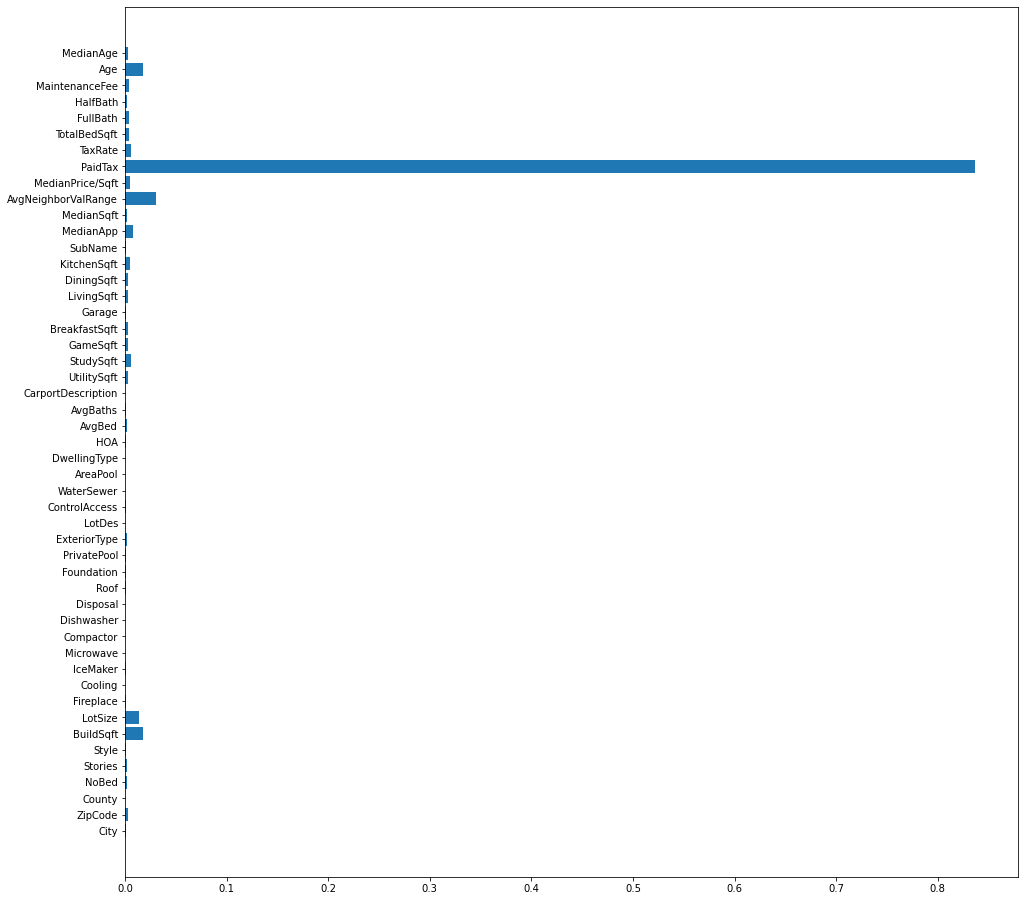

In [68]:
plt.figure(figsize=(16,16))
plt.barh(X.columns, best_model.feature_importances_)